In [22]:
import re 
import numpy as np 
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import defaultdict
from sklearn.decomposition import PCA

### Preprocess Data

In [23]:
# read amharic text from a file and return it as a string
def load_data(file_path):
    # read the file
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.readlines()

def consturct_paragraph(text):
    paragraph = []
    sentence = []
    for line in text:
        # remove the new line character and the leading and trailing white spaces
        word = line.split(' ')[0].strip()
        if word:
            sentence.append(word)
        # check if the word is a ge'ez script delimater
        if re.findall(r'(፡፡|።|\?|!|::)', word):
            # check if the sentence contains at list two words
            if len(sentence) > 1:
                paragraph.append(sentence)
            sentence = []
    return paragraph

def tokenize_text(text):
    cleaned_text = []
    for sentence in text:
        punctuation_pattern = r"[.,;()?!/\[\]{}'\"<>@#$%^&*_+=|~\-]"
        latin_pattern = r'[a-zA-Z0-9]+'
        # remove the punctuation marks
        cleaned_sentence = re.sub(punctuation_pattern, "፡፡", sentence)
        # remove the latin characters
        cleaned_sentence = re.sub(latin_pattern, '', cleaned_sentence)
        # remove the extra white spaces
        cleaned_sentence = re.sub(r"\s+", " ", cleaned_sentence).strip()
        # check if the sentence contains at list two words
        if len(sentence) > 1:
            cleaned_text.append(cleaned_sentence)
    
    tokenized_text = []
    sentence = []
    # pattern to split the text into words and delimaters
    pattern = r'\w+|[^\s\w]+'
    for line in cleaned_text:
        # split the line into words and delimaters and iterate over the words
        for word in re.findall(pattern, line):
            # check if the word is a ge'ez script delimater
            delimater = re.findall(r'(፡፡|።|::)', word)
            if delimater:
                # add the delimater to the sentence
                sentence.append(delimater[-1]) 
                # add the sentence to the tokenized text
                tokenized_text.append(sentence)
                sentence = []
            elif word:
                sentence.append(word)
            
    return tokenized_text

train_data, dev_data, test_data = load_data("../data/train.txt"), load_data("../data/dev.txt"), load_data( "../data/test.txt")
train_data, dev_data, test_data = consturct_paragraph(train_data), consturct_paragraph(dev_data), consturct_paragraph(test_data)

train_txt, dev_txt, test_txt = load_data("../data/train_.txt"), load_data("../data/dev_.txt"), load_data("../data/test_.txt")
train_txt = tokenize_text(train_txt)
dev_txt = tokenize_text(dev_txt)
test_txt = tokenize_text(test_txt)
train_data += train_txt
dev_data += dev_txt
test_data += test_txt
print(len(train_data), len(dev_data), len(test_data))
data = train_data + dev_data + test_data

1687 245 488


### Build CBOW Word Embedding Models

In [33]:
class AmhCBOW:
    def __init__(self, window_size=2, embedding_size=1000, alpha=0.01, epochs=10):
        # initialize the hyperparameters
        self.word2index = {}
        self.index2word = {}
        self.vocab = set()
        self.vocab_size = 0
        self.word_freq = defaultdict(int)
        self.word_count = 0
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.alpha = alpha
        self.epochs = epochs
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        self.h = []
        self.u = []
        self.y_hat = []
        self.loss = []
        self.embedding = None
    
    def build_vocab(self, data):
        '''
        Initialize the word2index and index2word dictionaries and the vocab set
        Parameters:
            data: list of list of strings
        Returns:
            None
        '''

        # build the vocab set and the word frequency dictionary
        for sentence in data:
            for word in sentence:
                self.word_freq[word] += 1
                self.word_count += 1
                self.vocab.add(word)

        # set the vocab size
        self.vocab_size = len(self.vocab)

        # build the word2index and index2word dictionaries
        for i, word in enumerate(sorted(self.vocab)):
            self.word2index[word] = i
            self.index2word[i] = word
    
    def initialize_weights(self):
        '''
        Initialize the weights and bias for the hidden layer and the output layer
        Parameters:
            None
        Returns:
            None
        '''
        # np.random.seed(1)
        # self.W1 = np.random.rand(self.embedding_size , self.vocab_size)
        # self.b1 = np.random.rand(self.embedding_size, 1)
        # self.W2 = np.random.rand(self.vocab_size, self.embedding_size)
        # self.b2 = np.random.rand(self.vocab_size, 1)

        self.W1 = np.random.uniform(-1, 1, (self.embedding_size , self.vocab_size))
        self.b1 = np.zeros((self.embedding_size, 1))
        self.W2 = np.random.uniform(-1, 1, (self.vocab_size, self.embedding_size))
        self.b2 = np.zeros((self.vocab_size, 1))
    
    def softmax(self, z):
        '''
        Compute the softmax of the input
        Parameters:
            z: numpy array
        Returns:
            numpy array
        '''
        exp = np.exp(z - np.max(z))
        return exp / exp.sum(axis=0)

    def forward_propagation(self, x, y):
        '''
        Compute the forward propagation
        Parameters:
            context: list of integers that represent the context 
        Returns:
            None
        '''
        
        # Compute the hidden layer
        self.h = self.W1 @ x + self.b1
        # Apply ReLU activation function on h
        self.h = np.maximum(0, self.h)
        # Compute the output layer
        self.u = self.W2 @ self.h + self.b2
        # Compute the softmax of the output layer
        self.y_hat = self.softmax(self.u)
    
    def compute_loss(self, y):
        '''
        Compute the loss
        Parameters:
            target: integer
        Returns:
            current loss: float
        '''
        loss = np.log(self.y_hat) * y
        loss = (-1 / self.word_count) * np.sum(loss)
        loss = np.squeeze(loss)
        self.loss.append(loss)
        return loss
    
    def back_propagation(self, x, y):
        '''
        Compute the back propagation
        Parameters:
            target: integer
        Returns:
            None
        '''
        z1 = self.W1 @ x + self.b1
        l1 = self.W2.T @ (self.y_hat - y) /  self.word_count
        l1[z1 < 0] = 0

        dW1 = l1 @ x.T
        db1 = np.sum(l1, axis=1, keepdims=True)
        dW2 = (self.y_hat - y) @ self.h.T  / self.word_count
        db2 = np.sum(self.y_hat - y, axis=1, keepdims=True) / self.word_count

        self.W1 -= self.alpha * dW1
        self.b1 -= self.alpha * db1
        self.W2 -= self.alpha * dW2
        self.b2 -= self.alpha * db2
    
    def word_to_one_hot(self, word):
        '''
        Convert the word to one hot encoding
        Parameters:
            word: string
        Returns:
            numpy array
        '''
        one_hot = np.zeros(self.vocab_size)
        one_hot[self.word2index[word]] = 1
        return one_hot
    
    def context_to_one_hot(self, indx, setence):
        '''
        Convert the context to one hot encoding
        Parameters:
            indx: integer
            setence: list of strings
        Returns:
            numpy array
        '''
        one_hot = [self.word_to_one_hot(setence[i]) for i in range(indx - self.window_size, indx + self.window_size + 1) if i != indx]
        one_hot = np.mean(one_hot, axis=0)
        return one_hot
    
    def train(self, data):
        '''
        Train the model
        Parameters:
            data: list of list of strings
        Returns:
            None
        '''
        self.build_vocab(data)
        self.initialize_weights()
        x, y = [], []
        for sentence in data:
            for i in range(self.window_size, len(sentence) - self.window_size):
                word = sentence[i]
                x.append(self.context_to_one_hot(i, sentence))
                y.append(self.word_to_one_hot(word)) 

        x = np.array(x).T 
        y = np.array(y).T 

        for epoch in range(1, self.epochs + 1):
            self.forward_propagation(x, y)
            self.compute_loss(y)
            self.back_propagation(x, y)
            if epoch % 100 == 0 or epoch == 1:
                print(f'Epoch {epoch} completed! >>>>>>>>>>>>>>>>>>>>>> Loss: {self.loss[-1]}')
        
        self.embedding = (self.W1.T + self.W2) * .5
    
    def get_embedding(self, word):
        '''
        Get the embedding of the word
        Parameters:
            word: string
        Returns:
            numpy array
        '''
        if word in self.vocab: 
            return self.embedding[self.word2index[word]]
        return None
    
    # def get_similar_words(self, word, n=5):
    #     '''
    #     Get the most similar words to the input word
    #     Parameters:
    #         word: string
    #         n: integer
    #     Returns:
    #         list of strings
    #     '''
    #     word_embedding = self.get_embedding(word)
    #     similarity = np.dot(self.W1, word_embedding)
    #     similar_words = [self.index2word[i] for i in np.argsort(similarity)[::-1][:n]]
    #     return similar_words

    def plot_loss(self):
        '''
        Plot the loss
        Parameters:
            None
        Returns:
            None
        '''
        plt.plot(self.loss)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch")
        plt.show()
    
    def plot_embedding(self, words):
        '''
        Plot the embedding of the words
        Parameters:
            words: list of strings
        Returns:
            None
        '''
        matplotlib.rcParams['font.family'] = 'Abyssinica SIL' 
        avg_embedding = (self.W1.T + self.W2) * .5
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(avg_embedding)
        idx = [self.word2index[word] for word in words]
        reduced_embeddings = reduced_embeddings[idx,:]
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
        for i, word in enumerate(words):
            plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
        plt.show()
    
    def save_model(self, file_path):
        '''
        Save the model
        Parameters:
            file_path: string
        Returns:
            None
        '''
        model = {
            "word2index": self.word2index,
            "index2word": self.index2word,
            "vocab_size": self.vocab_size,
            "embedding_size": self.embedding_size,
            "W1": self.W1,
            "b1": self.b1,
            "W2": self.W2,
            "b2": self.b2
        }
        np.save(file_path, model)
    
    def load_model(self, file_path):
        '''
        Load the model
        Parameters:
            file_path: string
        Returns:
            None
        '''
        model = np.load(file_path, allow_pickle=True).item()
        self.word2index = model["word2index"]
        self.index2word = model["index2word"]
        self.vocab_size = model["vocab_size"]
        self.embedding_size = model["embedding_size"]
        self.W1 = model["W1"]
        self.b1 = model["b1"]
        self.W2 = model["W2"]
        self.b2 = model["b2"]
    
    # def predict(self, context):
    #     '''
    #     Predict the word
    #     Parameters:
    #         context: list of integers
    #     Returns:
    #         string
    #     '''
    #     self.forward_propagation(context)
    #     return self.index2word[np.argmax(self.y)]
    
    # def evaluate(self, data):
    #     '''
    #     Evaluate the model
    #     Parameters:
    #         data: list of list of strings
    #     Returns:
    #         float
    #     '''
    #     correct = 0
    #     total = 0
    #     for sentence in data:
    #         for i, word in enumerate(sentence):
    #             context = [self.word2index[sentence[j]] for j in range(max(0, i - self.window_size), min(i + self.window_size + 1, len(sentence))) if j != i]
    #             prediction = self.predict(context)
    #             if prediction == word:
    #                 correct += 1
    #             total += 1
    #     return correct / total        

### Amharic Langauge Word Embedding with CBOW

Epoch 1 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 6.239534349627314
Epoch 100 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 5.600156364394017
Epoch 200 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 5.475044188801157
Epoch 300 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 5.351023918097072
Epoch 400 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 5.2500844978667915
Epoch 500 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 5.157799262708153
Epoch 600 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 5.067702291235431
Epoch 700 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 4.973330619672863
Epoch 800 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 4.873471683625091
Epoch 900 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 4.767051424878712
Epoch 1000 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 4.653305274806196
Epoch 1100 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 4.5317205713094575
Epoch 1200 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 4.401929810875486
Epoch 1300 completed! >>>>>>>>>>>>>>>>>>>>>> Loss: 4.262873852150092
Epoch 1400 completed! >>>>>>>>>>>>>>>>>>>>>>

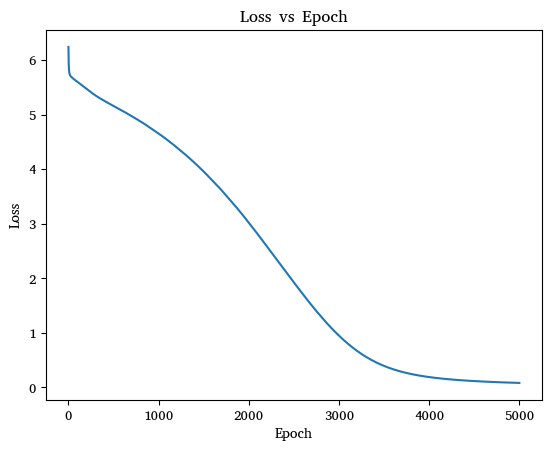

In [37]:
# create an instance of the AmhCBOW
cbow = AmhCBOW(window_size=2, embedding_size=100, alpha=2, epochs=5000)
cbow.train(data)
#print(cbow.get_embedding('በላ'))
#print(cbow.get_similar_words('በላ'))
cbow.plot_loss()

(2318, 100)
(2318, 2)
42


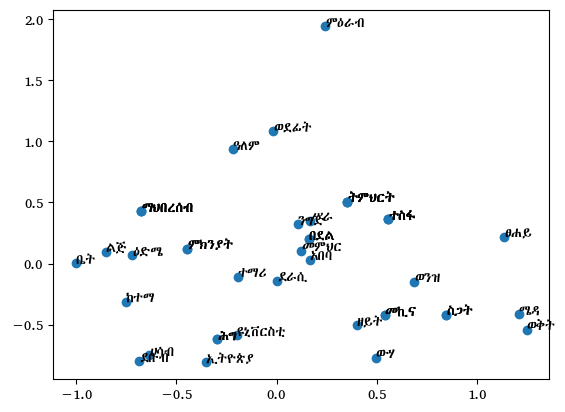

In [ ]:

%matplotlib inline
matplotlib.rcParams['font.family'] = 'Abyssinica SIL' 

avg_embedding = (cbow.W1.T + cbow.W2) * .5
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(avg_embedding)
print(avg_embedding.shape)
print(reduced_embeddings.shape)
amharic_words = [
    # People & Relationships (ሰዎች እና ግንኙነቶች)
    "አያት", "አባት", "እናት", "ወንድም", "እህት", "ልጅ", "ወላጅ", "ወንጀለኛ", "ጠበቃ", "መምህር",
    "ተማሪ", "ሐኪም", "ሙዚቀኛ", "ነጋዴ", "ጠባቂ", "ሰራተኛ", "አስተዳዳሪ", "ዳኛ", "ሳይንቲስት", "ደራሲ",
    
    # Places (ቦታዎች)
    "ከተማ", "ቤት", "አዳራሽ", "ሱቅ", "እስራኤል", "ኢትዮጵያ", "ደቡብ", "ምስራቅ",
    "ሰሜን", "ምዕራብ", "ሆቴል", "ኮሌጅ", "አምስተርዳም", "ዩኒቨርስቲ", "ቤተክርስትያን",
    
    # Objects (እቃዎች)
    "መጽሐፍ", "ስልክ", "መኪና", "ፒሲ", "ኮምፒዩተር", "ሰንደቅ", "ምንዛሬ", "መስኮት", "ጨርቅ", "ውሃ", "ዘይት", "ሳሙና", "መድሃኒት", "ድስት",
    
    # Nature (ተፈጥሮ)
    "ዓለም", "ጠፈር", "ፀሐይ", "ጨረቃ", "ከዋክብት", "ብርሃን", "ደመና", "ምስል", "በረዶ", "ዝናብ",
    "አትክልት", "አረም", "ዛፍ", "እንስሳ", "አየር", "አበባ", "ወንዝ", "ጎተራ", "ሜዳ",
    
    # Emotions (ስሜቶች)
    "ደስታ", "እሴት", "ሐዘን", "ተስፋ", "ስጋት", "ፍርሃት", "ተደስቷል",
    "ደስ ይላል", "ጥል", "ጭንቅ", "ስሜት", "ስሜት", "ስጋት", "ግልፅነት", "ድንጋጤ", "ሀዘን",
    
    # Concepts (ሀሳቦች)
    "ስኬት", "ድርጊት", "ሕግ", "ትምህርት", "እውቀት", "ጥንቅር", "መረጃ", "ማንኛውም", "ብልህነት", "ግልጽነት",
    "ምርጥ", "ምክንያት", "እሴት", "ወቅት", "ማህበረሰብ", "ወደፊት", "ምርምር", "ተስፋ", "ምሳሌ", "እሴት",
    
    # Actions (እርምጃዎች)
    "ድርጊት", "ውህደት", "ማንኛውም", "ማድረግ", "ትምህርት", "ማሳየት", "ምስክር", "አስተሳሰብ", "ምክንያት", "ስሜት",
    "የሚያስደንቅ", "አስተሳሰብ", "ስሜት", "ግልፅነት", "ሀሳብ", "ድርጊት", "ምስክር", "ምርጥ", "ማንኛውም", "ተስፋ",
    
    # Miscellaneous (ተለዋዋጭ)
    "ዕድሜ", "ግለሰብ", "ጥንብ", "ንግድ", "ቅርንጫፍ", "ሥራ", "ማንኛውም", "ምርት", "ስሜት", "አዝማድ",
    "ማንኛውም", "ውህደት", "በደል", "የትምህርት መረጃ", "ማህበረሰብ", "ትዕዛዝ", "አስተሳሰብ", "ምርጥ", "ሕግ", "ሰሞኑ",
    "ማንኛውም", "በደል", "ሕይወት", "አዝማድ", "ማንኛውም"
]
words = []
idx = []
for word in amharic_words:
    if word in cbow.vocab:
        words.append(word)
        idx.append(cbow.word2index[word])
print(len(words))
avg_embedding = avg_embedding[idx,:]
plt.scatter(avg_embedding[:, 0], avg_embedding[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(avg_embedding[i, 0], avg_embedding[i, 1]))
plt.show()